# Implementation Tasks

## Task 1

In [1]:
from pathlib import Path
from chop import MaseGraph
import pandas as pd

tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

/rds/general/user/oa321/home/miniforge3/envs/mase_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial2/tutorial_2_lora")

/rds/general/user/oa321/home/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not fou

In [3]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

baseline_res = trainer.evaluate()

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/rds/general/user/oa321/home/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
import chop.passes as passes

qc = {
    "by": "type",
    "default": {
        "config":
        {
            "name": None
        }
    },
    "linear":{
        "config":{
            "name":"integer",
            # Data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # Weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # Bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    }
}

mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial2/tutorial_2_lora")

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

mg, _ = passes.quantize_transform_pass(mg, pass_args=qc)

/rds/general/user/oa321/home/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not fou

In [9]:
eval_results = trainer.evaluate()
print(eval_results['eval_accuracy'])

0.82452


In [10]:
def search_fixed(qatOrPtq: bool) -> None:
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial2/tutorial_2_lora")
    frac_diff = ["" for i in range(0, 28)]
    frac_diff_acc = [0 for i in range(0, 28)]
    qc_template = qc

    for i in range(4, 32):
        qc_template["linear"]["config"]["bias_width"] = i
        qc_template["linear"]["config"]["data_in_width"] = i
        qc_template["linear"]["config"]["weight_width"] = i

        qc_template["linear"]["config"]["bias_frac_width"] = i / 2
        qc_template["linear"]["config"]["data_in_frac_width"] = i / 2
        qc_template["linear"]["config"]["weight_frac_width"] = i / 2

        qc_template['by'] = "type"
        mg, _ = passes.quantize_transform_pass(mg, qc_template)
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
        )

        if (qatOrPtq):
            trainer.train()

        eval_results = trainer.evaluate()
        frac_diff[i-4] = eval_results
        frac_diff_acc[i-4] = eval_results['eval_accuracy']

    data = []

    for i in range(4, 32):
        data.append({
            "width" : i,
            "accuracy": frac_diff_acc[i-4]
        })

    df = pd.DataFrame(data)
    df.to_csv(f"{Path.home()}/mase/tasks/tutorial3/out_{'qat' if qatOrPtq else 'pqt'}.csv", index=False)




In [ ]:
# Commented out Just so I dont run them again by accident, uncomment to run the search
# search_fixed(qatOrPtq=False)
# search_fixed(qatOrPtq=True)

In [80]:
import matplotlib.pyplot as plt


df_pqt = pd.read_csv(f'{Path.home()}/mase/tasks/tutorial3/out_pqt.csv')
df_qat = pd.read_csv(f'{Path.home()}/mase/tasks/tutorial3/out_qat.csv')

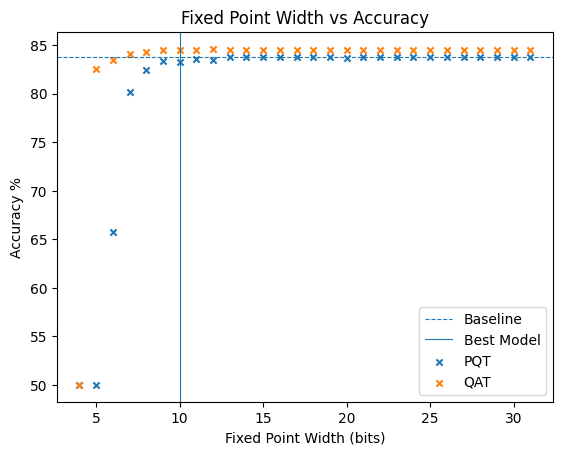

In [81]:
# Selecting 'Best' Model
df_pqt['daccdw'] = abs(df_pqt['accuracy'].diff() / df_pqt['width'].diff())
df_pqt.loc[df_pqt['daccdw'] == 0, 'daccdw'] = None
df_pqt['modded'] = df_pqt['daccdw'] * (df_pqt['width'] - 4)
df_qat['daccdw'] = abs(df_qat['accuracy'].diff() / df_qat['width'].diff())
df_qat['modded'] = df_qat['daccdw'] * (df_qat['width'] - 4)

min_qat_con = df_qat.loc[df_qat['modded'].idxmin()]
min_pqt_con = df_pqt.loc[df_pqt['modded'].idxmin()]
pqtOrQat = min_pqt_con['modded'] < min_qat_con['modded']
best_model_con = min_pqt_con if pqtOrQat else min_qat_con

# Optional Plot
# plt.figure()
# plt.scatter(x=df_pqt['width'], y=df_pqt['modded'], marker='x', s=20)
# plt.scatter(x=df_qat['width'], y=df_qat['modded'], marker='x', s=20)
# plt.axvline(x=best_model_con['width'], linestyle='-', linewidth=0.8)
# plt.legend(['PQT', 'QAT', 'Best Model'])

# Plot bits vs Accuracy
fig_pqt = plt.figure()
plt.axhline(y=baseline_res['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
plt.axvline(x=best_model_con['width'], linestyle='-', linewidth=0.8)
plt.scatter(x=df_pqt['width'], y=df_pqt['accuracy'] * 100, marker='x', s=20)
plt.scatter(x=df_qat['width'], y=df_qat['accuracy'] * 100, marker='x', s=20)
plt.legend(['Baseline', 'Best Model', 'PQT', 'QAT'])
plt.xlabel('Fixed Point Width (bits)')
plt.ylabel('Accuracy %')
plt.title('Fixed Point Width vs Accuracy')
plt.savefig(f'{Path.home()}/mase/tasks/tutorial3/fixed_point_explore')
plt.show()


In [82]:
# Save Model
mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial2/tutorial_2_lora")

qc_template = qc
qc_template["linear"]["config"]["bias_width"] = best_model_con['width']
qc_template["linear"]["config"]["data_in_width"] = best_model_con['width']
qc_template["linear"]["config"]["weight_width"] = best_model_con['width']
qc_template["linear"]["config"]["bias_frac_width"] = best_model_con['width'] / 2
qc_template["linear"]["config"]["data_in_frac_width"] = best_model_con['width'] / 2
qc_template["linear"]["config"]["weight_frac_width"] = best_model_con['width'] / 2
qc_template['by'] = "type"

mg, _ = passes.quantize_transform_pass(mg, qc_template)
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

if (pqtOrQat):
    trainer.train()

eval_results = trainer.evaluate()

/rds/general/user/oa321/home/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not fou

In [83]:
print(eval_results['eval_accuracy'])

0.83312


In [84]:
from pathlib import Path

mg.export(f"{Path.cwd()}/mase/tasks/tutorial3/best_model")

INFO     Exporting MaseGraph to /rds/general/user/oa321/home/mase/tasks/tutorial3/best_model.pt, /rds/general/user/oa321/home/mase/tasks/tutorial3/best_model.mz
INFO     Exporting GraphModule to /rds/general/user/oa321/home/mase/tasks/tutorial3/best_model.pt
INFO     Exporting MaseMetadata to /rds/general/user/oa321/home/mase/tasks/tutorial3/best_model.mz


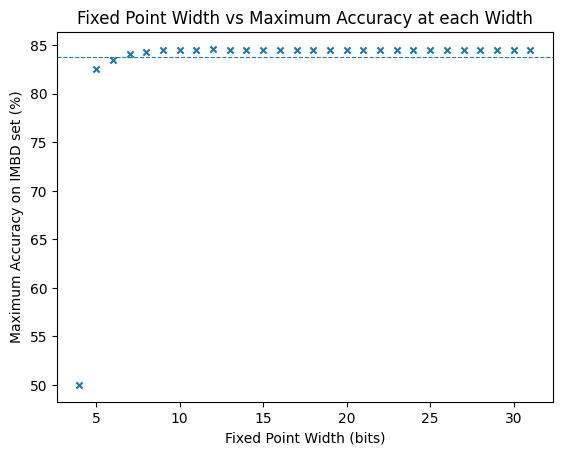

In [87]:
fig_max = plt.figure()
max_col = df_pqt['accuracy'].combine(df_qat['accuracy'], max)
plt.scatter(x=df_pqt['width'], y=max_col * 100, marker='x', s=20)
plt.axhline(y=baseline_res['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
plt.xlabel('Fixed Point Width (bits)')
plt.ylabel('Maximum Accuracy on IMBD set (%)')
plt.title('Fixed Point Width vs Maximum Accuracy at each Width')
plt.savefig(f'{Path.home()}/mase/tasks/tutorial3/tsk1a')
plt.show()
